In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pickle
from collections import defaultdict
from IPython.display import HTML
import keras

# Catch

Let's train a model to play catch using a similar algorithm to the one we used from [tic-tac-toe](../sessions/reinforcement.ipynb).

We start with functions to display the board, update the board, and determine game result.

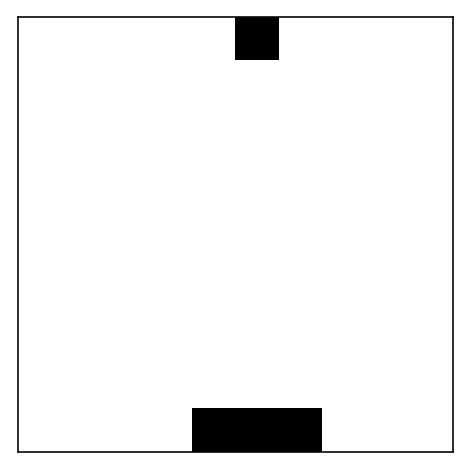

In [2]:
def display(board, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.imshow(board, cmap='gray_r')
    ax.set(xticks=[], yticks=[])

def create_board(size):
    board = np.zeros((size, size), dtype='int')
    n = size//2
    board[0, n] = 1 # rock
    board[-1, n-1:n+2] = 1 # basket
    
    return board

size = 10
board = create_board(size)
display(board)

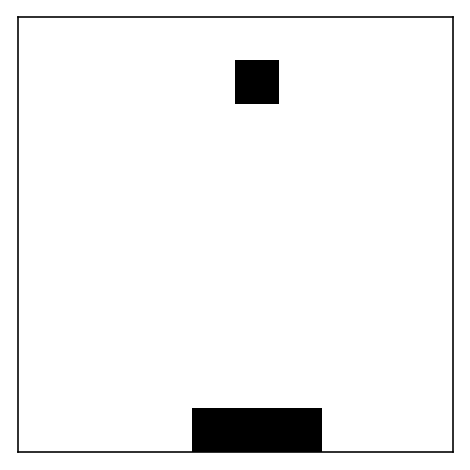

In [3]:
def update_rock(board):
    i, j = np.array(board[:-1,:].nonzero()).squeeze()
    board[i, j] = 0
    board[i + 1, j] = 1

update_rock(board)
display(board)

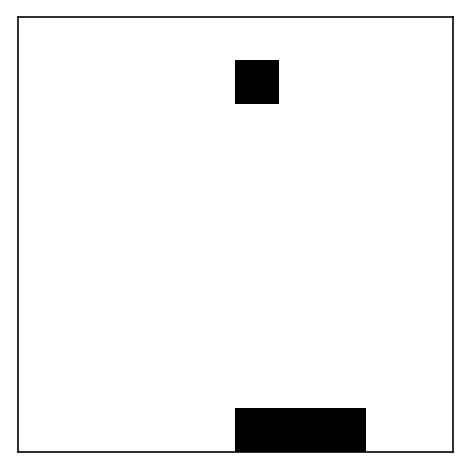

In [4]:
def update_basket(board, move):
    if move == 0: return
    j = board[-1, :].argmax() + 1
    left, right = j-1, j+2
    if left + move < 0:
        move = 0
    elif right + move > board.shape[1]:
        move = 0
    j += move
    board[-1, :] = 0
    board[-1, j-1:j+2] = 1
    
update_basket(board, 1)
display(board)

In [5]:
def get_reward(board):
    if board[-1, :].sum() == 3:
        return 1
    else:
        return -1
    
def random_move():
    return np.random.randint(-1, 2)

reward: -1


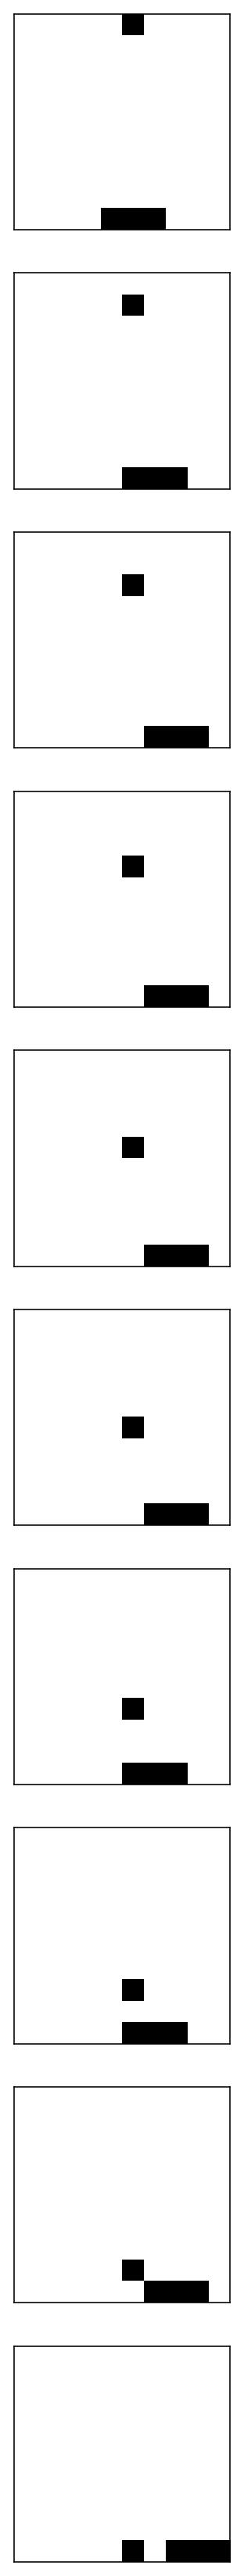

In [6]:
def display_game(boards):
    size = len(boards)
    fig, axes = plt.subplots(size, 1, figsize=(3, 3*size))
    for board, ax in zip(boards, axes):
        display(board, ax=ax)

board = create_board(size)
boards = [board.copy()]
for t in range(size-1):
    move = random_move()
    update_basket(board, move)
    update_rock(board)
    boards.append(board.copy())

display_game(boards)    
print('reward:', get_reward(board))

In [13]:
layers = [
    keras.layers.Dense(128, input_shape=(size**2,), activation='relu'),
    keras.layers.Dense(3),
    keras.layers.Activation('softmax')
]

model = keras.models.Sequential(layers)

In [14]:
model.compile(keras.optimizers.SGD(lr=.2), "mse")

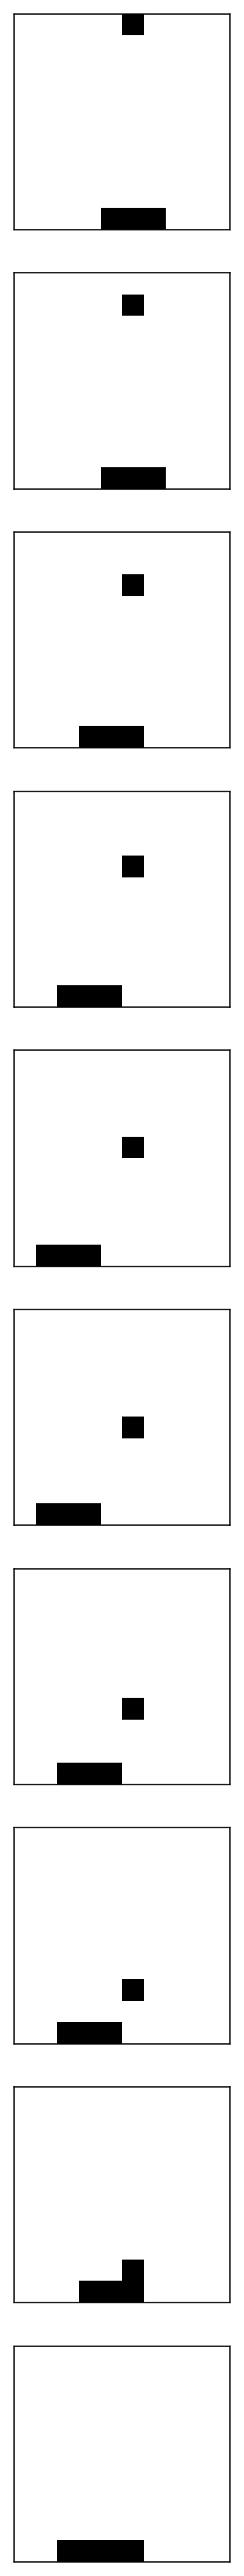

In [10]:
def play_game(size, ϵ=0.1):
    board = create_board(size)
    boards = [None for _ in range(size)]
    moves = [0] * size
    
    for t in range(size):
        boards[t] = board.copy()
            
        if np.random.rand() < ϵ:
            pred = np.ones(3) / 3
        else:
            pred = model.predict(board.reshape(1,-1)).ravel() # predict gives (1,9)
        move = np.random.multinomial(1, pred).argmax() - 1 # multinomial returns 0, 1 ,2
        moves[t] = move
        
        update_basket(board, move)
        update_rock(board)
    
    return boards, moves

boards, moves = play_game(size)
display_game([b for b in boards])

In [12]:
def score(size, reps=10000):
    boards = [play_game(size, ϵ=0)[0][-1] for _ in range(reps)]
    scores = np.array([get_reward(b) for b in boards])
    return scores.mean()

print('Score', score(size))

Score -0.0776


In [25]:
def train_on_game(boards, moves):
    reward = get_reward(boards[-1])
    X = np.empty((len(boards), size*size))
    Y = np.empty((len(boards), 3))
    for t, (board, move) in enumerate(zip(boards, moves)):
        X[t] = board.reshape(size*size)
        y = np.zeros(3)
        y[move] = reward
        Y[t] = y

    loss = model.train_on_batch(X, Y)
    return loss

In [26]:
num_of_games = 1000

for i in range(num_of_games):
    boards, moves = play_game(size)
    loss = train_on_game(boards, moves)
    if i % (num_of_games//10) == 0:
        print("{}: loss={}".format(i, loss))

0: loss=0.2070346176624298
100: loss=0.21871483325958252
200: loss=0.21701522171497345
300: loss=0.6650770902633667
400: loss=0.6493685245513916
500: loss=0.6454905271530151
600: loss=0.21829068660736084
700: loss=0.2313365638256073
800: loss=0.6638518571853638
900: loss=0.6498275995254517


In [ ]:
print('Score', score(size))